In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import librosa
import soundfile as sf

from tqdm.notebook import tqdm
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchaudio.compliance import kaldi
import torch.nn.functional as F
import json, requests, timm
from collections import defaultdict

pd.set_option('display.max_columns', None)

In [2]:
data_dir = '/workspace/tmp/'

df_audios = pd.read_csv(f'{data_dir}/metadata.csv')

df_audios = df_audios[~df_audios.isnull().any(axis=1)]
df_audios = df_audios[df_audios['file_name'].str.contains("wav")]
df_audios['file_exists'] = df_audios['file_name'].apply(lambda x: os.path.exists(f"{data_dir}/{x}"))

df_audios = df_audios[df_audios['file_exists']].copy().reset_index(drop=True)

# index 8044 is broken
df_audios = df_audios.drop(8044)
df_audios = df_audios.reset_index(drop=True)

print(df_audios.shape)

df_audios.head(5)

(23120, 8)


,location,sub_location,location_id,timestamp,sampling_rate,mp3_path,file_name,file_exists
0,Inhaa,Inhaa-Be Audiomoth 2,Inhaa_2,2024-04-05 12:40:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/I...,data/Inhaa_2_20240405T124000_5.wav,True
1,Inhaa,Inhaa-Be Audiomoth 2,Inhaa_2,2024-04-05 12:45:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/I...,data/Inhaa_2_20240405T124500_39.wav,True
2,Inhaa,Inhaa-Be Audiomoth 2,Inhaa_2,2024-04-05 12:50:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/I...,data/Inhaa_2_20240405T125000_40.wav,True
3,Inhaa,Inhaa-Be Audiomoth 2,Inhaa_2,2024-04-05 12:55:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/I...,data/Inhaa_2_20240405T125500_3.wav,True
4,Inhaa,Inhaa-Be Audiomoth 2,Inhaa_2,2024-04-05 13:00:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/I...,data/Inhaa_2_20240405T130000_25.wav,True


In [3]:
class BirdAudioMAEDataset(Dataset):

    def __init__(self, df_audio_meta, dataset_dir, sampling_rate=16_000):
        self.df_audio_meta = df_audio_meta
        self.dataset_dir = dataset_dir
        self.sampling_rate = sampling_rate
        self.global_mean = -4.2677393
        self.global_std = 4.5689974

    def __len__(self):
        return len(self.df_audio_meta)

    def preprocess(self, x: torch.Tensor):
        x = x - x.mean()
        melspec = kaldi.fbank(x.unsqueeze(0), htk_compat=True, window_type="hanning", num_mel_bins=128)
        if melspec.shape[0] < 1024:
            melspec = F.pad(melspec, (0, 0, 0, 1024 - melspec.shape[0]))
        else:
            random_start = np.random.randint(0, len(melspec)-1025)
            melspec = melspec[random_start:random_start+1024]
        melspec = (melspec - self.global_mean) / (self.global_std * 2)
        return melspec

    def __getitem__(self, idx):
        row = self.df_audio_meta.iloc[idx]
        audio_path = f"{self.dataset_dir}/{row['file_name']}"
        # load audio file
        audio_arr, sr = librosa.load(audio_path, sr=self.sampling_rate)
        # get the spectrogram
        spec = self.preprocess(torch.tensor(audio_arr))
        return spec

In [4]:
TAG = "gaunernst/vit_base_patch16_1024_128.audiomae_as2m_ft_as20k"
MODEL = timm.create_model(f"hf_hub:{TAG}", pretrained=True)

LABEL_URL = "https://huggingface.co/datasets/huggingface/label-files/raw/main/audioset-id2label.json"
AUDIOSET_LABELS = list(json.loads(requests.get(LABEL_URL).content).values())

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

batch_size = 512

dataset = BirdAudioMAEDataset(df_audios, data_dir)
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=2)

probs_collect, classes_collect = [], []

MODEL.to(DEVICE)
MODEL.eval()

# ~ 1.5 hours
for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):

    # if i == 0:
    #     print("Example Spectrogram:")
    #     plt.figure(figsize=(9, 2))
    #     plt.imshow(data[0].numpy().T, aspect='auto', origin='lower', cmap='cool')
    #     plt.colorbar()
    #     plt.show()
    try:
        data = data.to(DEVICE)
        with torch.no_grad():
            logits = MODEL(data.unsqueeze(1))
            topk_probs, topk_classes = logits.sigmoid().topk(10)

        probs_collect.append(topk_probs.cpu().numpy())
        classes_collect.append(topk_classes.cpu().numpy())
        
    except Exception as e:
        print(f"Error at batch {i}: {e}")
        break

    if (i+1) % 100 == 0:
        print(f"Finished {i+1} batches")

cuda


  0%|          | 0/46 [00:00<?, ?it/s]

In [5]:
# aggregate all results
all_probs = np.concatenate(probs_collect)
all_classes = np.concatenate(classes_collect)

class_cols = [f'class_{i+1}' for i in range(10)]
proba_cols = [f'probability_{i+1}' for i in range(10)]

df_results = pd.DataFrame(
    np.concatenate([all_classes, all_probs], axis=1),
    columns = class_cols + proba_cols
)

df_results[class_cols] = df_results[class_cols].astype(int)
df_results[proba_cols] *= 100

id_to_label = {i: v for i, v in enumerate(AUDIOSET_LABELS)}
for _col in class_cols:
    df_results[_col] = df_results[_col].map(id_to_label)
    
df_audios_labels = df_audios.join(df_results, how='left').dropna()

display(df_audios_labels.head())

df_audios_labels.to_csv(f"{data_dir}/Audio_Segment_Labels.csv", index=False)

,location,sub_location,location_id,timestamp,sampling_rate,mp3_path,file_name,file_exists,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8,class_9,class_10,probability_1,probability_2,probability_3,probability_4,probability_5,probability_6,probability_7,probability_8,probability_9,probability_10
0,Inhaa,Inhaa-Be Audiomoth 2,Inhaa_2,2024-04-05 12:40:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/I...,data/Inhaa_2_20240405T124000_5.wav,True,Insect,Cricket,Frog,Animal,Croak,"Outside, rural or natural","Fly, housefly",Bird,Environmental noise,"Bird vocalization, bird call, bird song",76.013625,62.996387,13.091637,2.258528,1.421953,1.389542,0.717809,0.640297,0.620304,0.598851
1,Inhaa,Inhaa-Be Audiomoth 2,Inhaa_2,2024-04-05 12:45:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/I...,data/Inhaa_2_20240405T124500_39.wav,True,Insect,Cricket,Frog,Environmental noise,"Outside, rural or natural",Animal,"Bird vocalization, bird call, bird song",Owl,Bird,Croak,66.100079,42.222026,6.131464,2.546338,1.936206,1.928192,1.363543,1.283651,1.210041,0.793817
2,Inhaa,Inhaa-Be Audiomoth 2,Inhaa_2,2024-04-05 12:50:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/I...,data/Inhaa_2_20240405T125000_40.wav,True,Insect,Cricket,Frog,"Outside, rural or natural",Environmental noise,Animal,"Bird vocalization, bird call, bird song",Bird,"Fly, housefly",Owl,77.583522,65.534467,2.911282,2.717582,2.400038,2.345129,1.131789,0.891499,0.654713,0.583400
3,Inhaa,Inhaa-Be Audiomoth 2,Inhaa_2,2024-04-05 12:55:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/I...,data/Inhaa_2_20240405T125500_3.wav,True,Cricket,Insect,Animal,"Outside, rural or natural",Frog,Clip-clop,"Bird flight, flapping wings",Horse,Environmental noise,"Bird vocalization, bird call, bird song",61.503100,57.713717,10.122114,9.987235,6.532434,4.766602,4.302964,4.132795,3.663298,3.051227
4,Inhaa,Inhaa-Be Audiomoth 2,Inhaa_2,2024-04-05 13:00:00,48000,/content/drive/MyDrive/Colab Notebooks/Audio/I...,data/Inhaa_2_20240405T130000_25.wav,True,Insect,Cricket,Frog,"Outside, rural or natural",Mosquito,"Fly, housefly",Animal,Bird,"Bird vocalization, bird call, bird song",Croak,86.311132,75.891358,6.330761,4.441360,4.272222,3.769732,3.019954,1.590680,1.147359,0.903703


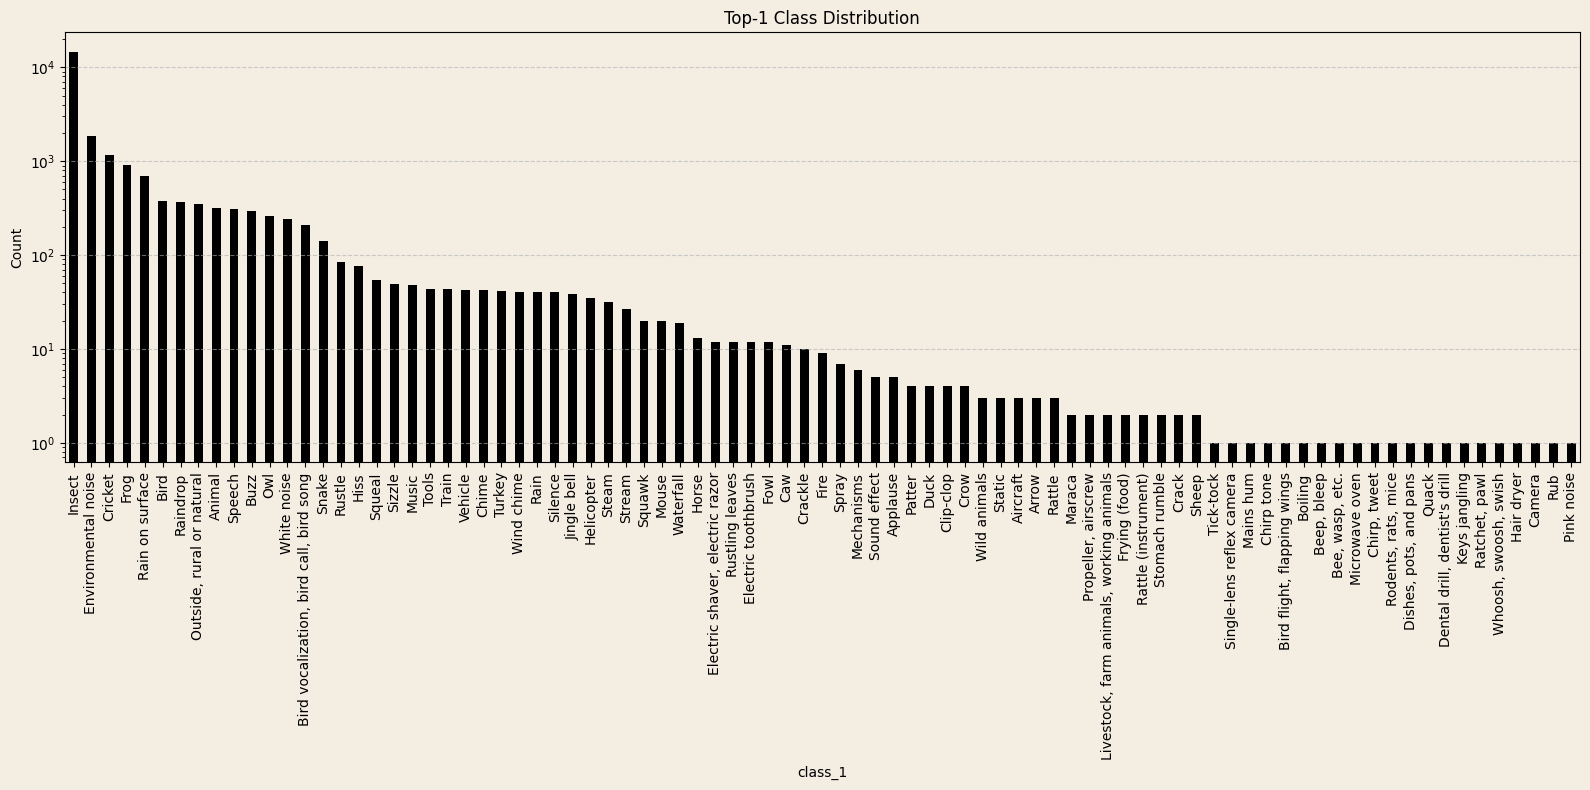

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
df_audios_labels['class_1'].value_counts().plot(kind='bar', ax=ax, color='k')
ax.set_ylabel("Count")
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_title("Top-1 Class Distribution")
ax.set_facecolor('#f3ede2')
fig.set_facecolor('#f3ede2')
plt.yscale('log')
fig.tight_layout()
fig.savefig(f"{data_dir}/Top1_Class_Distribution.png")
plt.show()